In [ ]:
#CAPSTONE EDA FOR EXPLORING RELATIONSHIP BETWEEN REGIGIOUS/SPIRITUAL PRACTICES ON HAPPINESS

In [2]:
import pandas as pd


df = pd.read_csv("Data/WVS_Cross-National_Wave_7_csv_v6_0_2.csv", low_memory=False)

pd.set_option("display.max_columns", None)  
pd.set_option("display.max_rows", None)   
pd.set_option("display.float_format", "{:.2f}".format)  

In [3]:
#print(df.describe())

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97220 entries, 0 to 97219
Columns: 613 entries, version to v2xps_party
dtypes: float64(195), int64(406), object(12)
memory usage: 454.7+ MB


In [5]:
def explore_column_uniques(df, max_unique_display=15):
    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        num_unique = len(unique_vals)
        print(f"\n-- Column: {col}")
        print(f"Unique values count: {num_unique}")
        if num_unique <= max_unique_display:
            print(f"Unique values: {sorted(unique_vals)}")
        else:
            print(f"Too many unique values to display ({num_unique} total). Showing first {max_unique_display}:")
            print(f"{sorted(unique_vals)[:max_unique_display]}")

In [6]:
#explore_column_uniques(df)

In [7]:
import pandas as pd
import re

# Replace missing value codes with NaN
missing_codes = [-1, -2, -3, -4, -5]
df.replace(missing_codes, pd.NA, inplace=True)

# Filter "Q" columns as these are the questions
q_columns = [col for col in df.columns if col.startswith("Q") and col[1:].isdigit()]
df = df[q_columns]

# Convert object columns to numeric (vectorized)
object_cols = df.select_dtypes(include='object').columns
df[object_cols] = df[object_cols].apply(pd.to_numeric, errors='coerce')

#Drop non-numeric columns (already happens due to conversion, but safe to apply)
df = df.select_dtypes(include='number')

# Display summary
print(f"Final number of numeric 'Q' columns: {df.shape[1]}")
print(df.dtypes.head())

Final number of numeric 'Q' columns: 291
Q1    float64
Q2    float64
Q3    float64
Q4    float64
Q5    float64
dtype: object


In [8]:
#for col in df.columns:
    #print(col)

In [9]:
import pandas as pd

#  Copy the original DataFrame
without_nan = df.copy()

#Drop columns with >20% missing values
threshold = 0.2
cols_to_drop = without_nan.columns[without_nan.isna().mean() > threshold]
clean_df = without_nan.drop(columns=cols_to_drop)

# Fill remaining NaNs with mode (safely, no inplace=True)
for col in clean_df.columns:
    if clean_df[col].isna().any():
        mode_value = clean_df[col].mode()
        if not mode_value.empty:
            clean_df[col] = clean_df[col].fillna(mode_value[0])

# Drop remaining rows with any NaNs (should be minimal now)
final_df = clean_df.dropna()

# Compare shapes and data loss
print(f"Original shape:     {df.shape}")
print(f"After column drop:  {clean_df.shape}")
print(f"Final clean shape:  {final_df.shape}")
print(f"Columns dropped:    {len(cols_to_drop)}")
print(f"Rows dropped total: {df.shape[0] - final_df.shape[0]}")

# See which columns were dropped
print("\nDropped columns (>{:.0f}% NaN):".format(threshold * 100))
print(cols_to_drop.tolist())

Original shape:     (97220, 291)
After column drop:  (97220, 277)
Final clean shape:  (97220, 277)
Columns dropped:    14
Rows dropped total: 0

Dropped columns (>20% NaN):
['Q82', 'Q85', 'Q86', 'Q89', 'Q91', 'Q92', 'Q93', 'Q223', 'Q240', 'Q276', 'Q280', 'Q282', 'Q284', 'Q293']


In [10]:
question_mapping = {
    # Happiness
    'Q46_reversed': 'Overall Happiness Level (Reversed)',
    'Q48': 'Freedom of Choice and Control',

    # Religious/Spirituality Attributes
    'Q164': 'Importance of God in Life',
    'Q165': 'Belief in God',
    'Q166': 'Belief: Life after Death',
    'Q167': 'Belief: Heaven',
    'Q168': 'Belief: Hell',
    'Q171': 'Frequency of Attending Religious Services',
    'Q172': 'Frequency of Prayer',
    'Q173': 'Religious Self-Identification',
    'Q174': 'Religion Provides Meaning in Life',
    'Q175': 'Religious Faith Important for Children',

    # Health
    'Q47': 'Self-Reported Health',

    # Household Financial Satisfaction
    'Q50': 'Financial Satisfaction',
    'Q51': 'Gone Without Enough Food',
    'Q54': 'Gone Without Cash Income',

    # Work and Employment
    'Q279': 'Employment Status',
    'Q281': 'Occupation Group',
    'Q286': 'Household Financial Behavior',

    # Security/Crime Exposure
    'Q131': 'Feeling of Safety Walking Alone at Night',
    'Q144': 'Victim of Crime (Self)',

    # Social Capital / Trust
    'Q57': 'Trust: Most People',
    'Q58': 'Trust: Family',
    'Q59': 'Trust: Neighbors',
    'Q60': 'Trust: Known People',
    'Q61': 'Trust: Strangers',
    'Q62': 'Trust: People of Other Religions',
    'Q63': 'Trust: People of Other Nationalities',

    # Marital Status and Children
    'Q273': 'Marital Status',
    'Q274': 'Number of Children',

    # Political Freedom and Trust
    'Q250': 'Importance of Living in a Democracy',
    'Q251': 'Satisfaction with Political System',
    'Q252': 'Trust: Parliament',

    # Education
    'Q275': 'Education Level',

    # Ethnicity and Discrimination
    'Q290': 'Ethnic Group Belonging',
    'Q19': 'Willing to Have as Neighbors: People of Different Race',
    'Q23': 'Willing to Have as Neighbors: Immigrants/Foreign Workers',
    'Q26': 'Willing to Have as Neighbors: People of a Different Religion',

    # Community Connection
    'Q255': 'Feeling of Belonging to City/Town',
    'Q256': 'Feeling of Belonging to Country',
    'Q257': 'Feeling of Belonging to Continent',
    'Q258': 'Feeling of Belonging to the World',
    'Q259': 'Importance of Community Belonging',

    # Relationships and Social Ties
    'Q135': 'Importance of Family',
    'Q136': 'Importance of Friends',
    'Q138': 'Frequency of Spending Time with Family',
    'Q139': 'Frequency of Spending Time with Friends',
    'Q142': 'Satisfaction with Family Life',
    'Q143': 'Satisfaction with Friendships',
    'Q145': 'Do People Help Each Other in Your Area',
    'Q147': 'How Often Feel Lonely',
    'Q148': 'Number of People to Rely on in Emergency',

    # Group Membership Indicators
    'Q94': 'Member of Church or Religious Organization',
    'Q95': 'Member of Sport or Recreational Organization',
    'Q96': 'Member of Art, Music, or Educational Organization',
    'Q97': 'Member of Labor Union',
    'Q98': 'Member of Political Party',
    'Q99': 'Member of Environmental Organization',
    'Q100': 'Member of Professional Organization',
    'Q101': 'Member of Charitable Organization',
    'Q102': 'Member of Consumer Organization',
    'Q103': 'Member of Self-Help Group or Mutual Aid Society',
    'Q104': 'Member of Women’s Group',
    'Q105': 'Member of Peace Movement',
    'Q106': 'Member of Human Rights Organization',
    'Q107': 'Member of Youth Organization',
    'Q108': 'Member of Older People’s Organization',
    'Q109': 'Member of Other Organization',

    #Reversed Members
    'Q47_reversed': 'Health Status (Reversed)',
    'Q51_reversed': 'Gone Without Food (Reversed)',
    'Q54_reversed': 'Gone Without Cash Income (Reversed)',
    'Q131_reversed': 'Feeling of Security',
    'Q165_belief': 'Belief in God (Mapped)',
    'Q166_belief': 'Belief in Afterlife (Mapped)',
    'Q167_belief': 'Belief in Hell (Mapped)',
    'Q168_belief': 'Belief in Heaven (Mapped)',
    'Q171_reversed': 'Frequency of Attending Religious Services (Reversed)',
    'Q172_reversed': 'Frequency of Praying (Reversed)',

    #Additional correlation items
    'Q1_reversed' : 'Family Importance (Reversed)',
    'Q27_reversed': 'Make Parents Proud',
    'Q53': 'Gone without medicine',
    'Q45_reversed': 'Respect for authority',
    'Q46': 'Overall Happiness',
    'Q47': 'Self-Reported Health',
    'Q48': 'Freedom of Choice and Control',
    'Q49': 'Life Satisfaction',
    'Q50': 'Financial Satisfaction',
    'Q51': 'Gone Without Enough Food',
    'Q54': 'Gone Without Cash Income',
    'Q58': 'Trust: Family',
    'Q59': 'Trust: Neighbors',
    'Q64': 'Confidence in Churches',
    'Q69_reversed': 'Confidence in Police',
    'Q71_reversed': 'Confidence in Government',
    'Q72': 'Confidence in Political Parties',
    'Q73': 'Confidence in Parliament',
    'Q74': 'Confidence in Civil Service',
    'Q75': 'Confidence in Universities',
    'Q76_reversed': 'Confidence in Elections',
    'Q77': 'Confidence in Major Companies',
    'Q78': 'Confidence in Banks',
    'Q79': 'Confidence in Environmental Organizations',
    'Q80': 'Confidence in Women’s Organizations',
    'Q81': 'Confidence in Charitable/Humanitarian Organizations',
    'Q131': 'Feeling of Safety Walking Alone at Night',
    'Q250': 'Importance of Living in Democracy',
    'Q251': 'Perceived Democratic Governance',
    'Q252': 'Satisfaction with Political System',
    'Q253': 'Respect for Individual Human Rights',
    'Q254_reversed': 'National Pride (Reversed)',
    'Q286_reversed': 'Family Saved Money',
    'Q287_reversed': 'Self-Described Social Class (Upper Class is higher)',
    'Q288': 'Perceived Household Income Group',

    # Happiness and Life
    'Q46_reversed': 'Overall Happiness (Reversed: Higher = Happier)',
    'Q47_reversed': 'Self-Reported Health (Reversed: Higher = Healthier)',
    'Q48': 'Freedom of Choice and Control',
    'Q49': 'Life Satisfaction',
    'Q50': 'Financial Satisfaction',

    # Basic Needs (Gone Without)
    'Q51_reversed': 'Gone Without Enough Food (Reversed)',
    'Q52_reversed': 'Gone Without Shelter (Reversed)',
    'Q53_reversed': 'Gone Without Medicine (Reversed)',
    'Q54_reversed': 'Gone Without Cash Income (Reversed)',
    'Q56_reversed': 'Gone Without Necessary Clothing (Reversed)',

    # Trust and Confidence (Reversed)
    'Q58_reversed': 'Trust in Family (Reversed)',
    'Q59_reversed': 'Trust in Neighbors (Reversed)',
    'Q64_reversed': 'Confidence in Churches (Reversed)',
    'Q72_reversed': 'Confidence in Political Parties (Reversed)',
    'Q73_reversed': 'Confidence in Parliament (Reversed)',
    'Q74_reversed': 'Confidence in Civil Service (Reversed)',
    'Q75_reversed': 'Confidence in Universities (Reversed)',
    'Q77_reversed': 'Confidence in Major Companies (Reversed)',
    'Q78_reversed': 'Confidence in Banks (Reversed)',
    'Q79_reversed': 'Confidence in Environmental Organizations (Reversed)',
    'Q80_reversed': 'Confidence in Women’s Organizations (Reversed)',
    'Q81_reversed': 'Confidence in Charitable/Humanitarian Organizations (Reversed)',

    # Safety and Loneliness
    'Q131_reversed': 'Feeling of Security Walking Alone at Night (Reversed)',
    'Q147_reversed': 'How Often Feel Lonely (Reversed)',

    # Religious Practice and Belief
    'Q171_reversed': 'Attendance at Religious Services (Reversed)',
    'Q172_reversed': 'Frequency of Prayer (Reversed)',

    # Belief Columns (Binary Mapped)
    'Q165_belief': 'Belief in God (Yes = 1, No = 0)',
    'Q166_belief': 'Life is Meaningful Because God Exists (Yes = 1, No = 0)',
    'Q167_belief': 'Belief in Heaven (Yes = 1, No = 0)',
    'Q168_belief': 'Belief in Hell (Yes = 1, No = 0)'
    
}


In [11]:
def prepare_data(df):
    df = df.copy()  # Ensure we're not modifying the original input

    def reverse_column(original, max_val):
        reversed_col = f"{original}_reversed"
        if reversed_col not in df.columns:
            df.loc[:, reversed_col] = max_val + 1 - df[original]

    # Questions with values 1–4 that need reversal
    reverse_1_to_4 = [
        'Q1', 'Q71','Q27','Q76','Q69','Q45',
        'Q46', 'Q56', 'Q58', 'Q59',
        'Q64', 'Q72', 'Q73', 'Q74', 'Q75', 'Q77', 'Q78', 'Q79', 'Q80', 'Q81',
        'Q131', 'Q147','Q253','Q286'
    ]
    for col in reverse_1_to_4:
        if col in df.columns:
            df = df[df[col].between(1, 4)].copy()
            reverse_column(col, 4)

    # Questions with values 1–10 (no reversal)
    for col in ['Q48', 'Q49', 'Q50']:
        if col in df.columns:
            df = df[df[col].between(1, 10)].copy()

    # Single reversals with custom max value
    single_reversals = {
        'Q47': 5,
        'Q287': 5,
        'Q254': 5,
        'Q171': 7,
        'Q172': 8
    }
    for col, max_val in single_reversals.items():
        if col in df.columns:
            df = df[df[col].between(1, max_val)].copy()
            reverse_column(col, max_val)

    return df


In [12]:
ordered_df = prepare_data(final_df)

In [13]:
print(f"Final number of numeric 'Q' columns: {ordered_df.shape[1]}")
print(ordered_df.dtypes.head())

Final number of numeric 'Q' columns: 306
Q1    float64
Q2    float64
Q3    float64
Q4    float64
Q5    float64
dtype: object


In [14]:
 # Drop original uncorrected columns
#ordered_df = ordered_df.drop(columns=['Q46', 'Q47', 'Q51', 'Q54', 'Q131', 'Q171', 'Q172','Q165', 'Q166', 'Q167', 'Q168', 'Q147', 'Q290' ])

In [15]:
# Drop original columns that have a _reversed counterpart
prepared_df = prepare_data(final_df)
reversed_cols = [col for col in prepared_df.columns if col.endswith('_reversed')]
original_cols = [col.replace('_reversed', '') for col in reversed_cols]

# Only drop the originals if they exist (to avoid duplicates)
cols_to_drop = [col for col in original_cols if col in prepared_df.columns]
prepared_df = prepared_df.drop(columns=cols_to_drop)

print(f"Final Shape: {prepared_df.shape}")
print(prepared_df.dtypes.head())

Final Shape: (97220, 277)
Q2    float64
Q3    float64
Q4    float64
Q5    float64
Q6    float64
dtype: object


In [16]:
# Get correlations
correlations = prepared_df.corr(numeric_only=True)['Q46_reversed'].sort_values(key=abs, ascending=False)

# Display top 30 correlations with question labels
print("\nTop 30 correlations with Q46 (Happiness):\n")
for question_code, corr_value in correlations.head(30).items():
    question_text = question_mapping.get(question_code, f"Unknown ({question_code})")
    print(f"{question_code: <15} | {corr_value:>5.2f} | {question_text}")


Top 30 correlations with Q46 (Happiness):

Q46_reversed    |  1.00 | Overall Happiness (Reversed: Higher = Happier)
Q49             |  0.44 | Life Satisfaction
Q47_reversed    |  0.37 | Self-Reported Health (Reversed: Higher = Healthier)
Q50             |  0.34 | Financial Satisfaction
Q48             |  0.24 | Freedom of Choice and Control
Q131_reversed   |  0.19 | Feeling of Security Walking Alone at Night (Reversed)
Q254_reversed   |  0.15 | National Pride (Reversed)
Q288            |  0.14 | Perceived Household Income Group
Q287_reversed   |  0.14 | Self-Described Social Class (Upper Class is higher)
Q54             |  0.14 | Gone Without Cash Income
Q253_reversed   |  0.14 | Unknown (Q253_reversed)
Q58_reversed    |  0.13 | Trust in Family (Reversed)
Q53             |  0.13 | Gone without medicine
Q71_reversed    |  0.13 | Confidence in Government
Q78_reversed    |  0.13 | Confidence in Banks (Reversed)
Q75_reversed    |  0.12 | Confidence in Universities (Reversed)
Q252         

In [17]:
#PRINT THE CORRELATION MATRIX

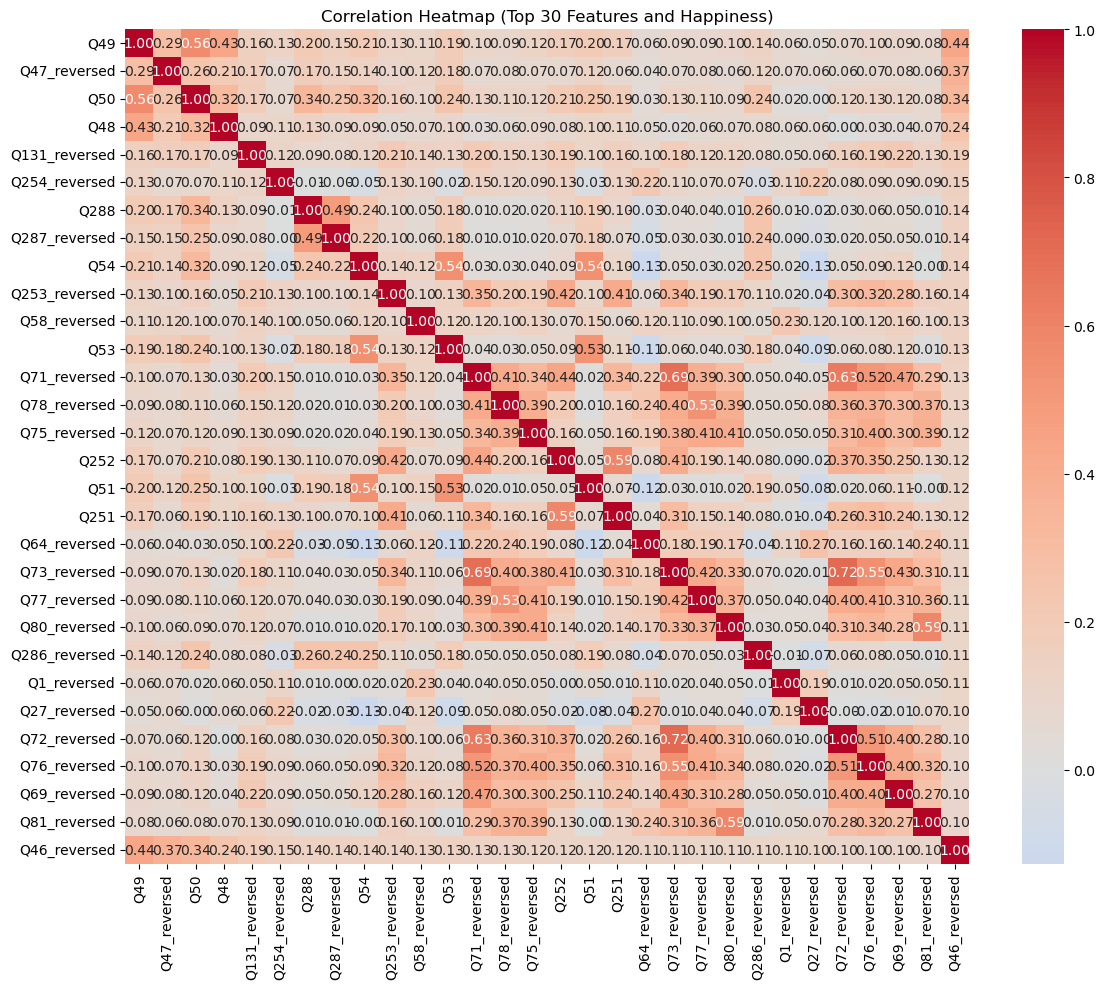

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

top_features = correlations.head(30).index.drop('Q46_reversed')

corr_matrix = prepared_df[top_features.tolist() + ['Q46_reversed']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Top 30 Features and Happiness)")
plt.tight_layout()
plt.show()

In [19]:
#PLOT THE FEATURE TO HAPPINESS BOX PLOTS

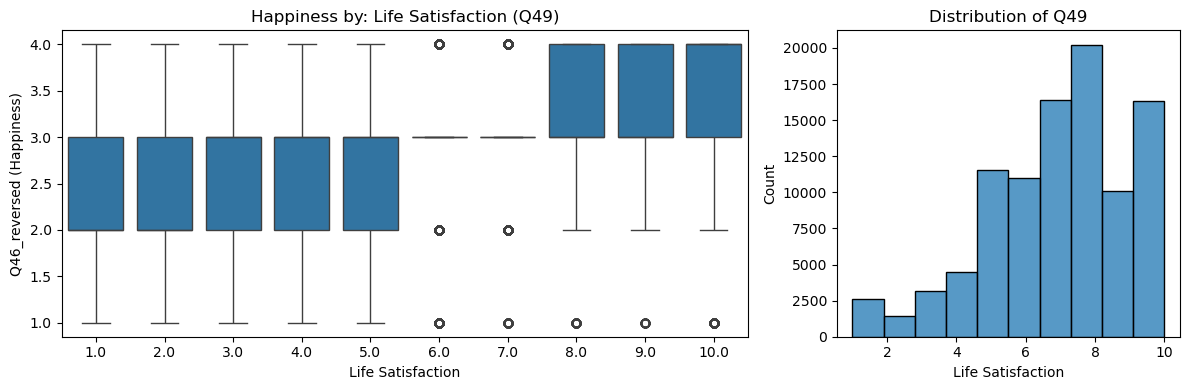

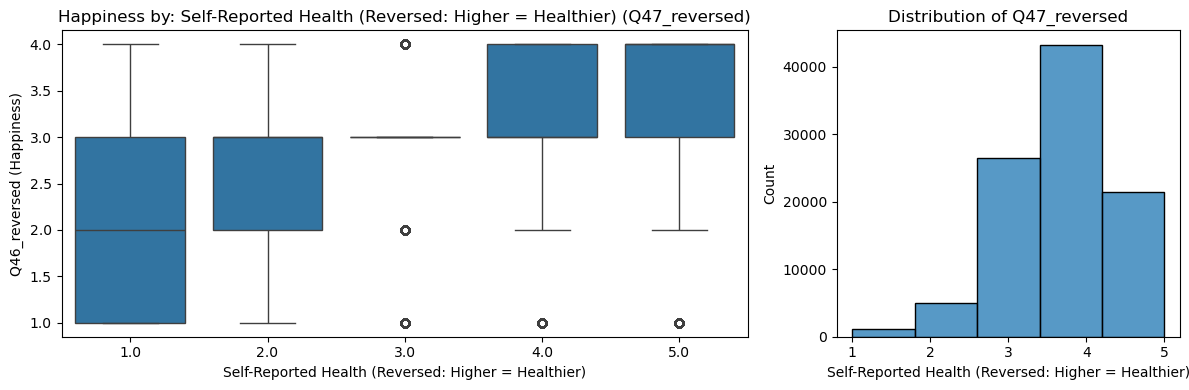

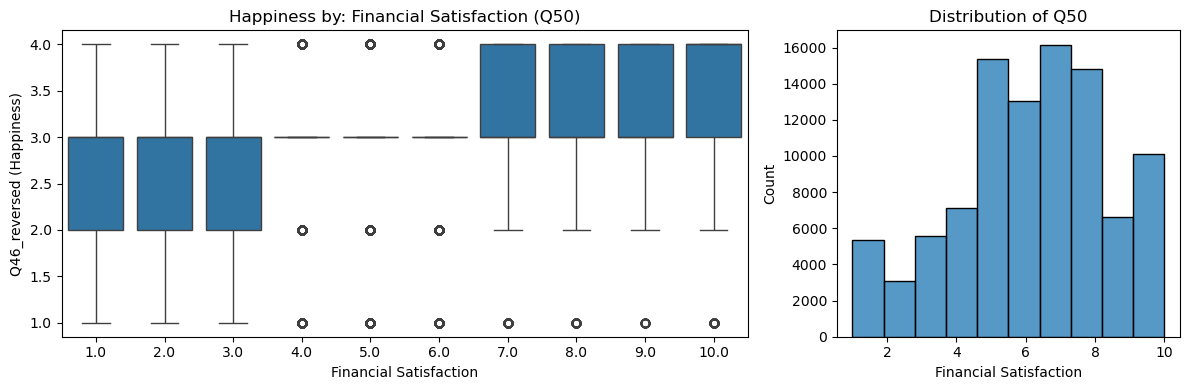

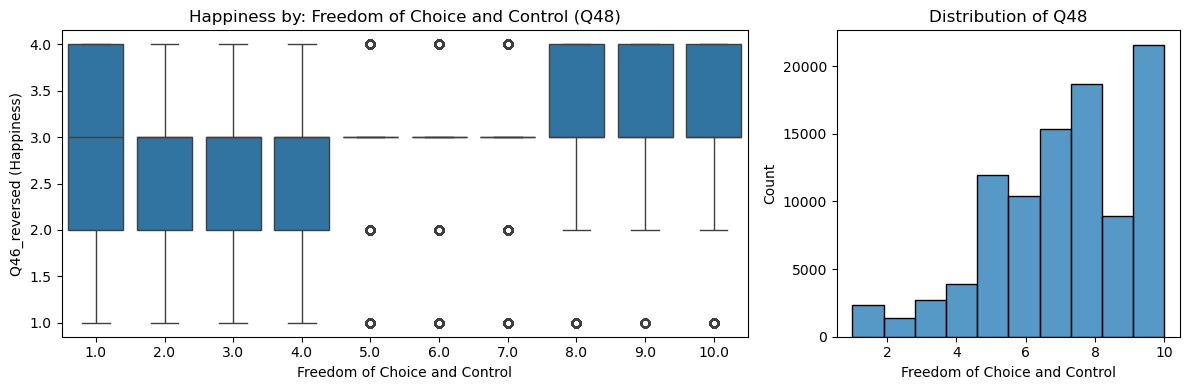

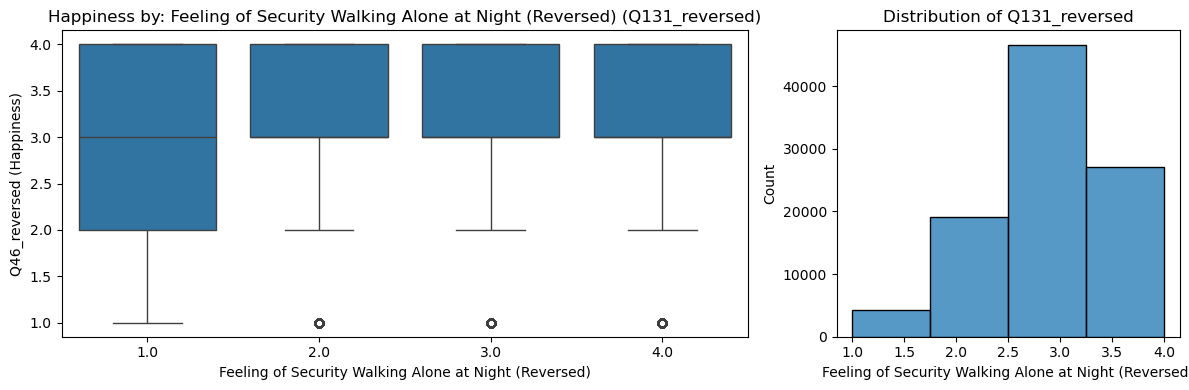

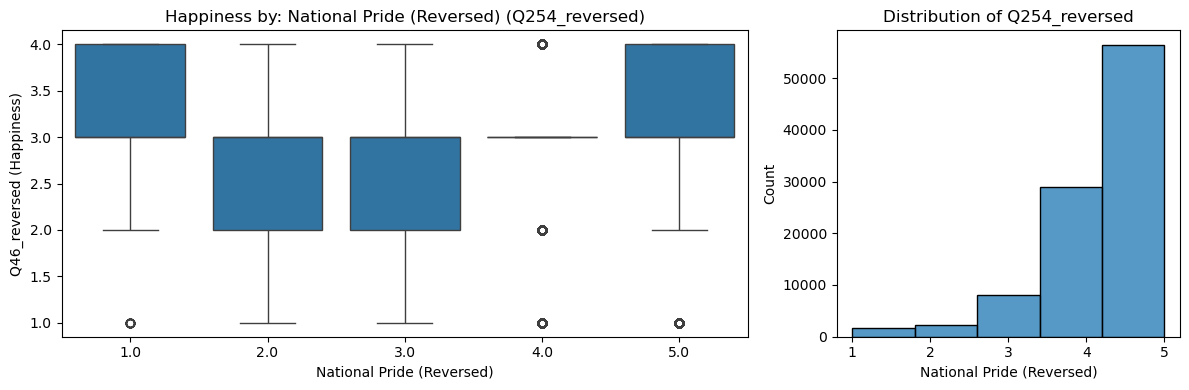

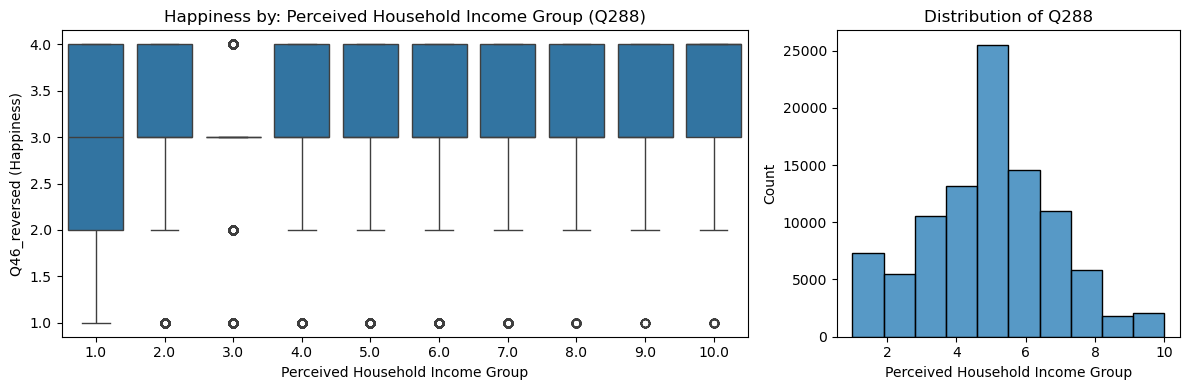

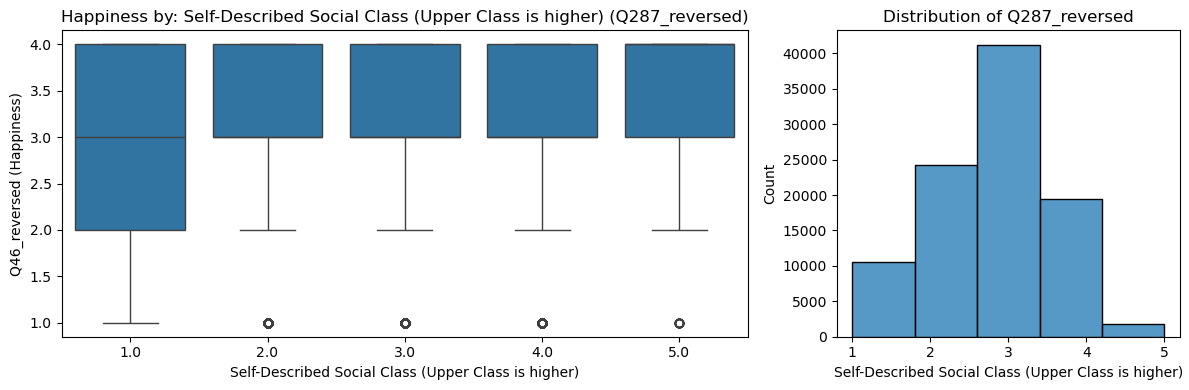

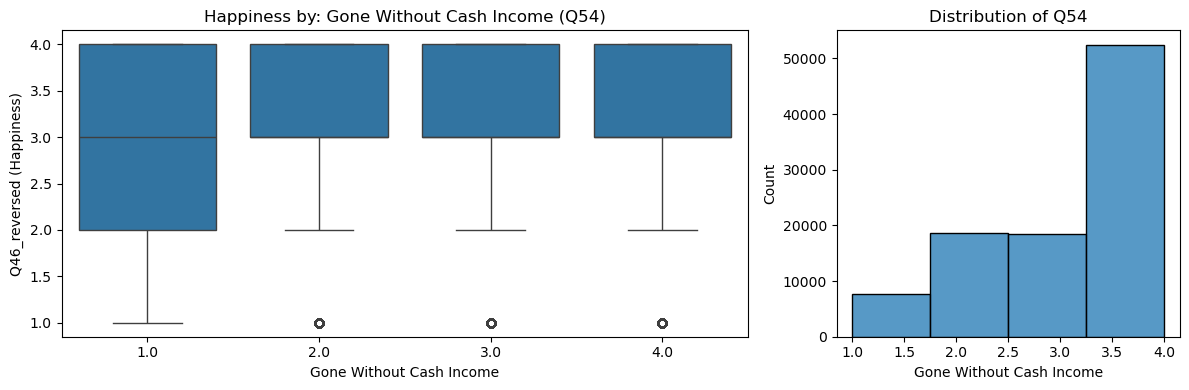

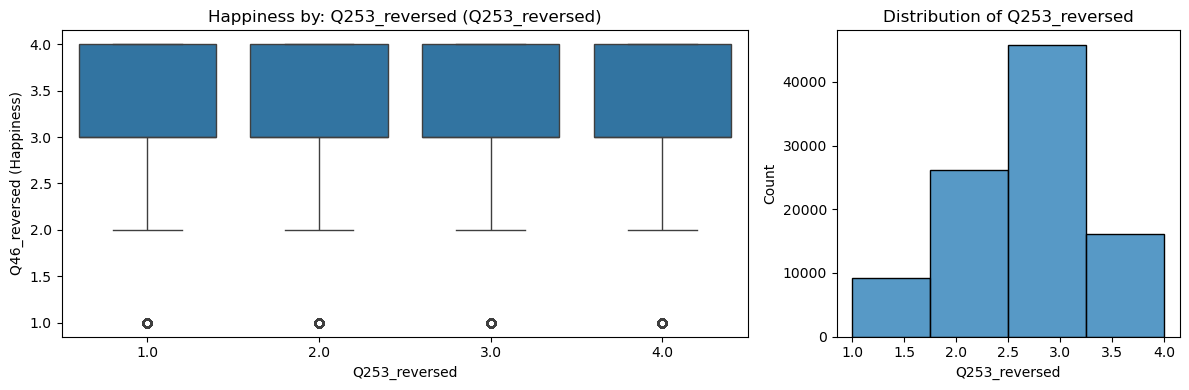

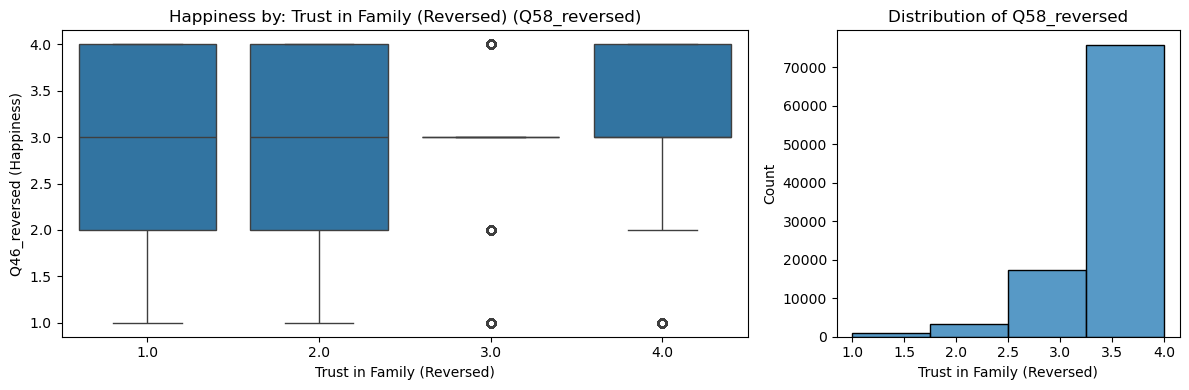

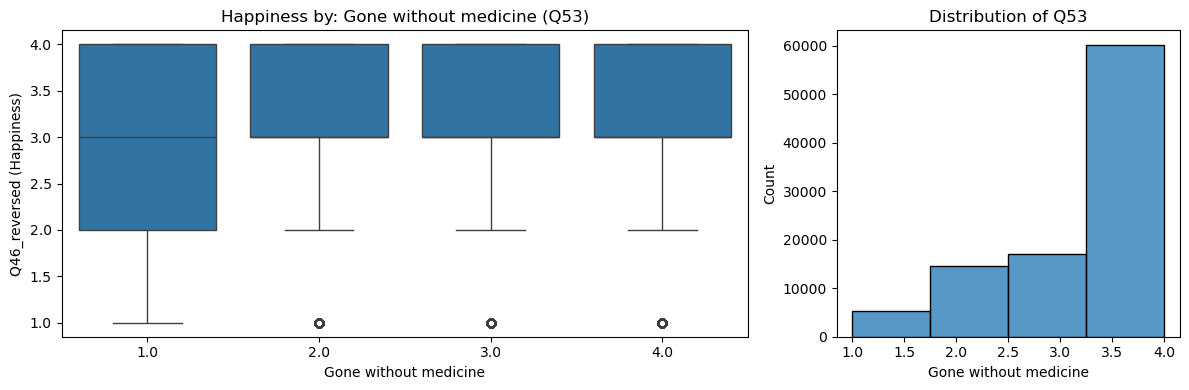

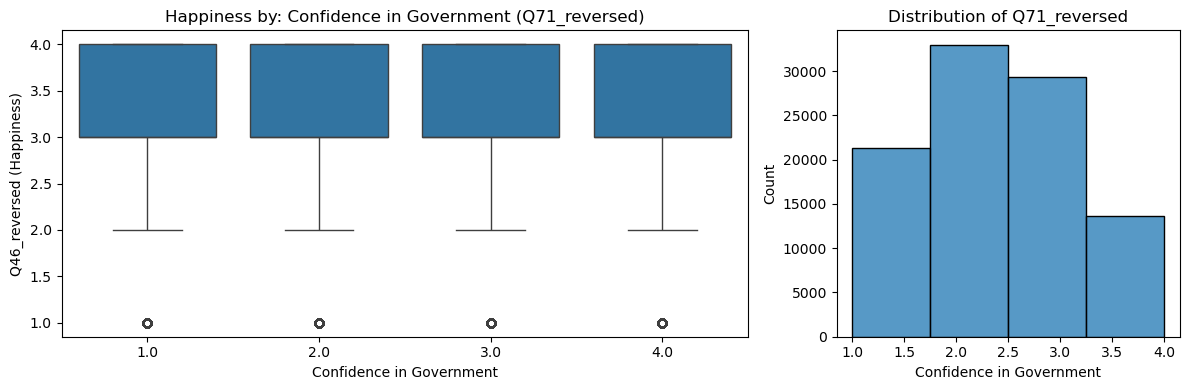

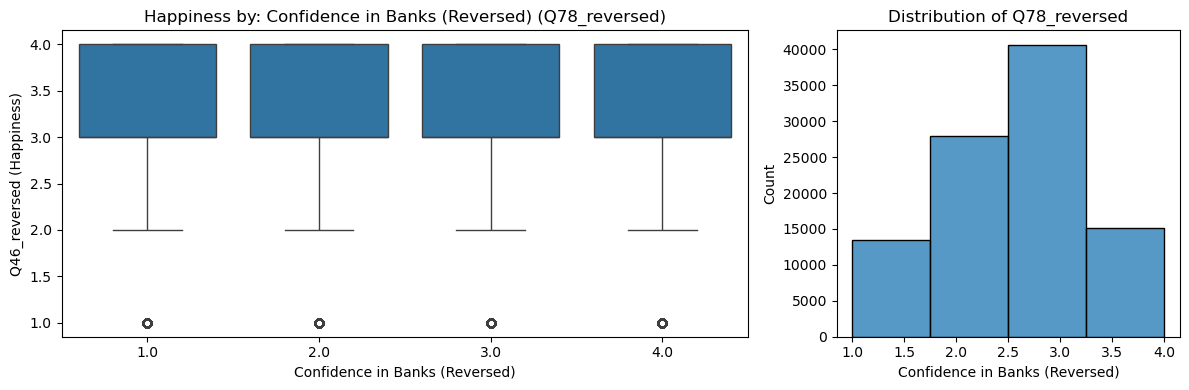

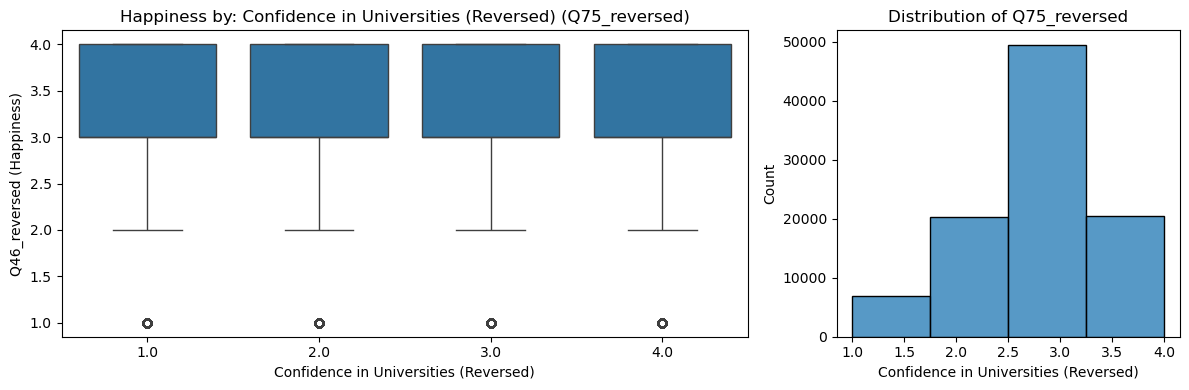

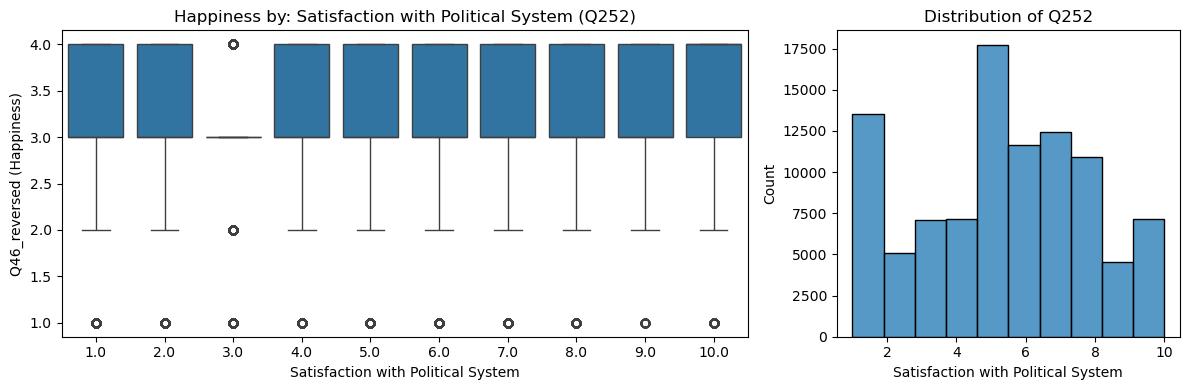

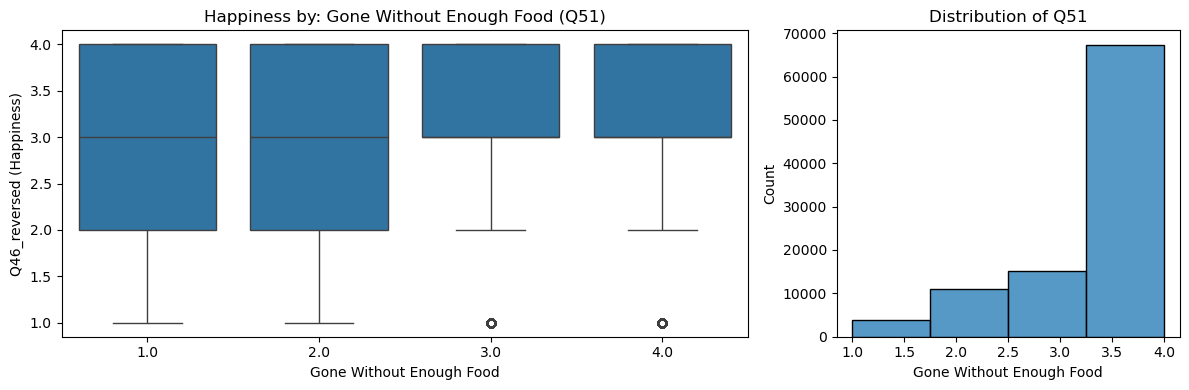

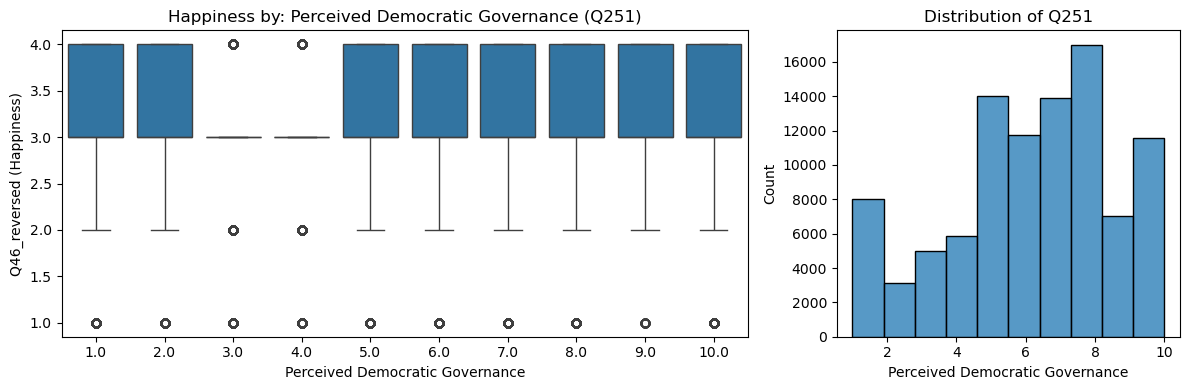

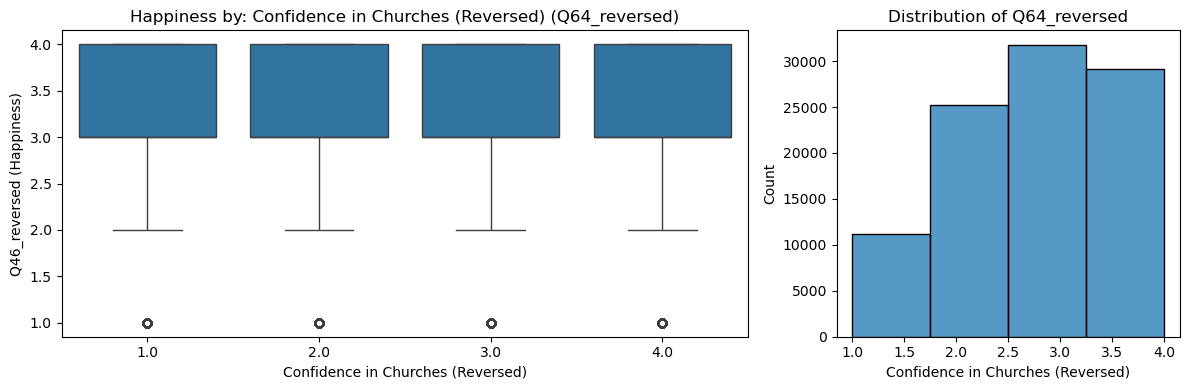

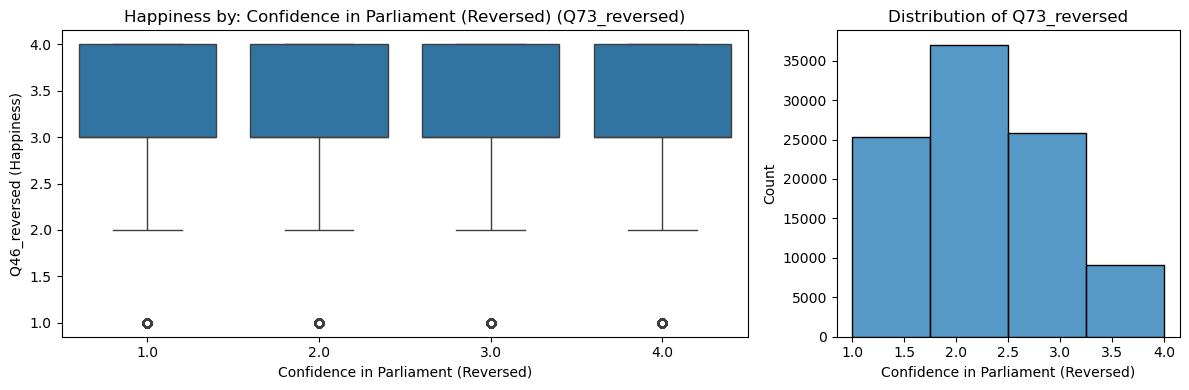

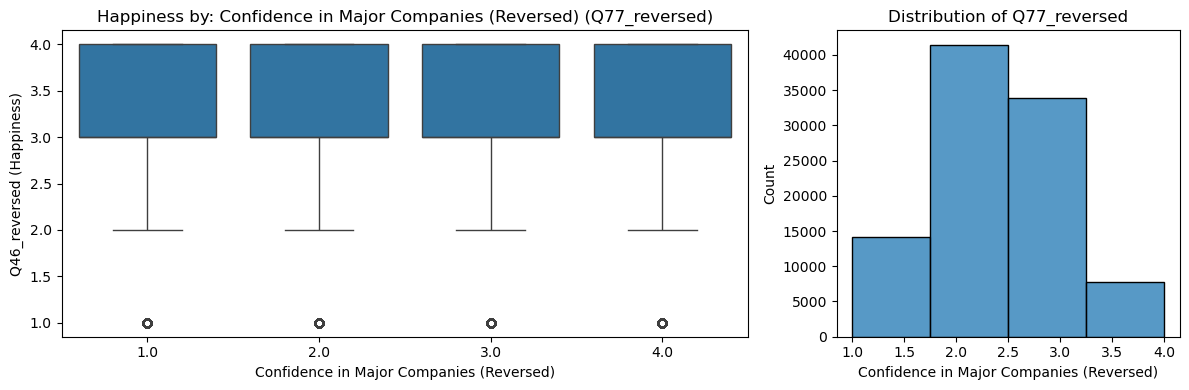

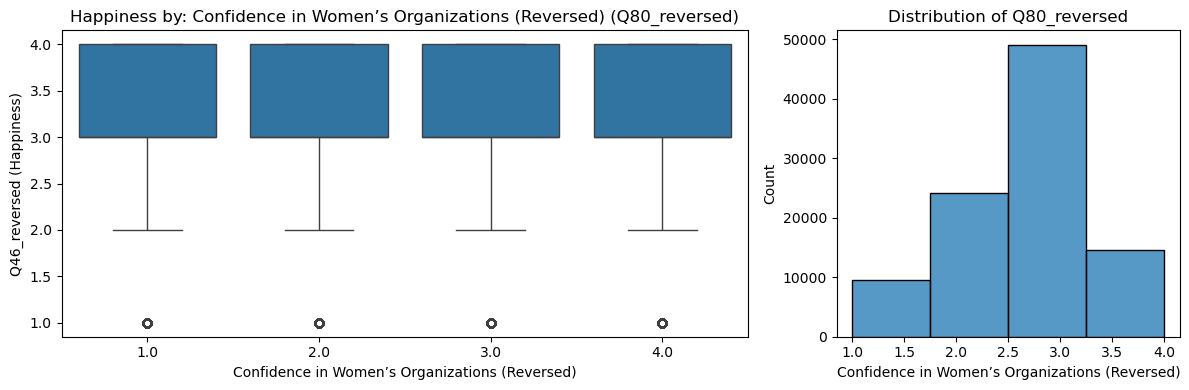

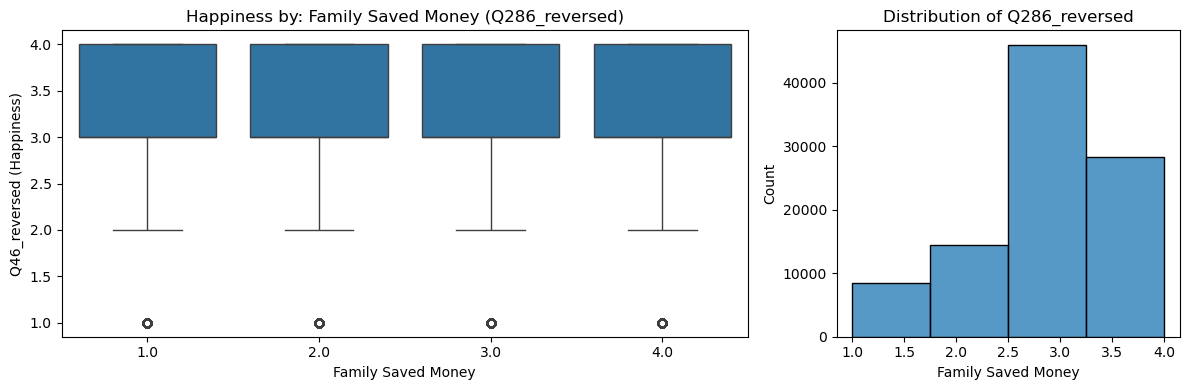

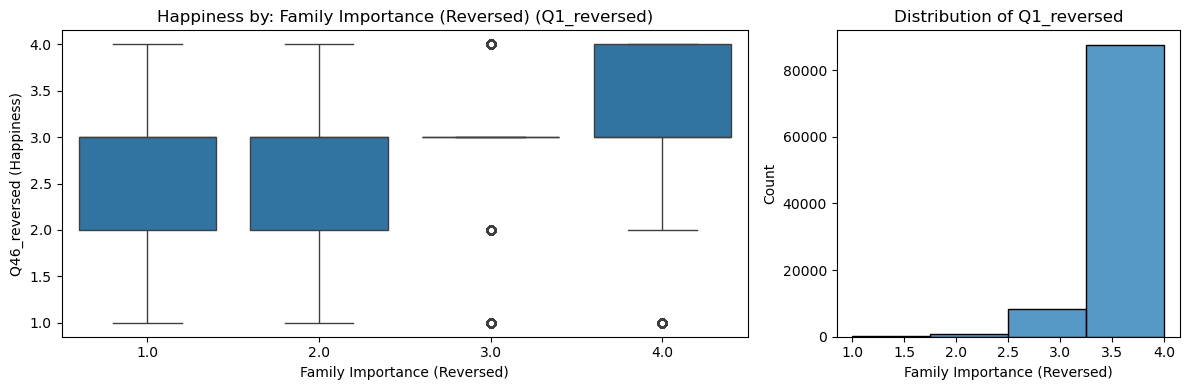

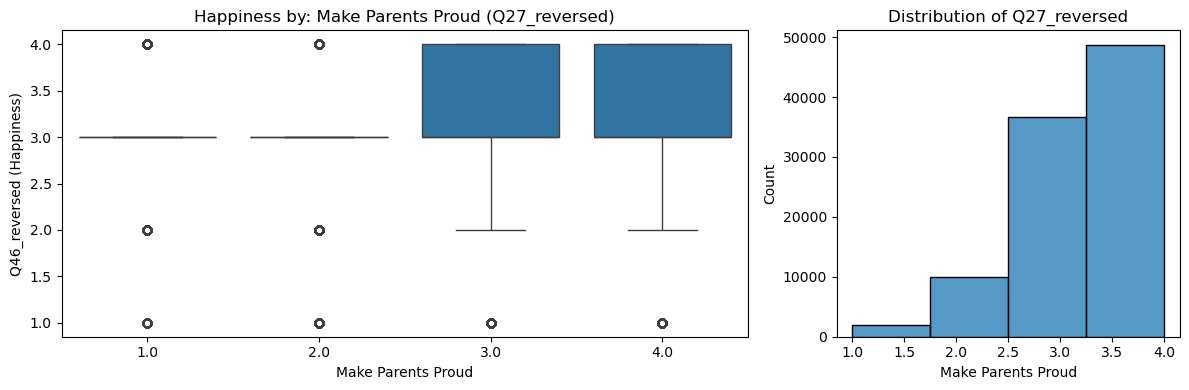

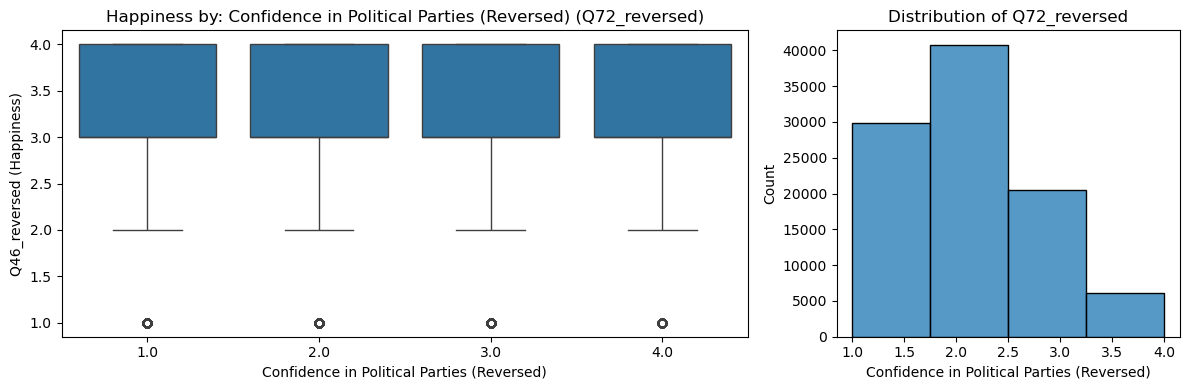

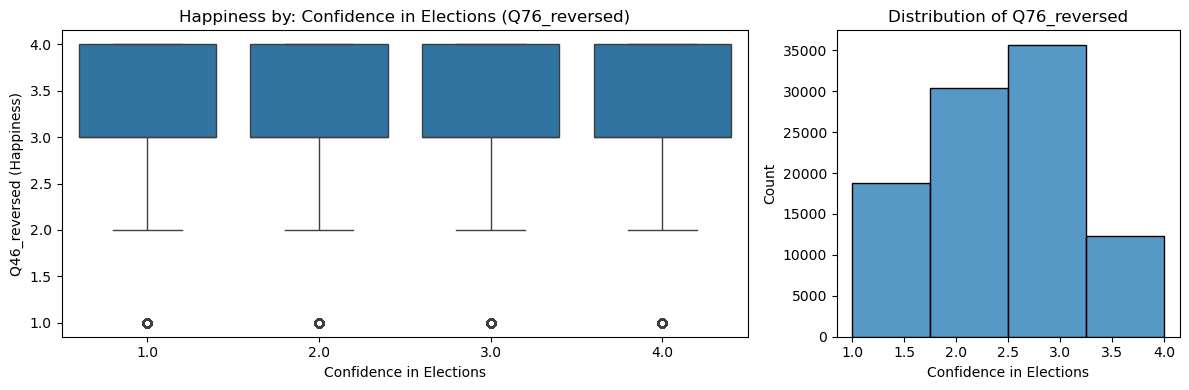

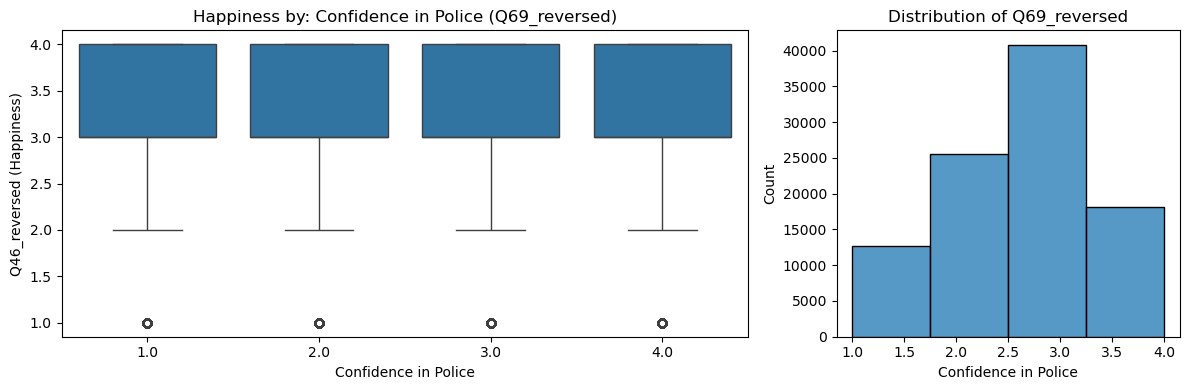

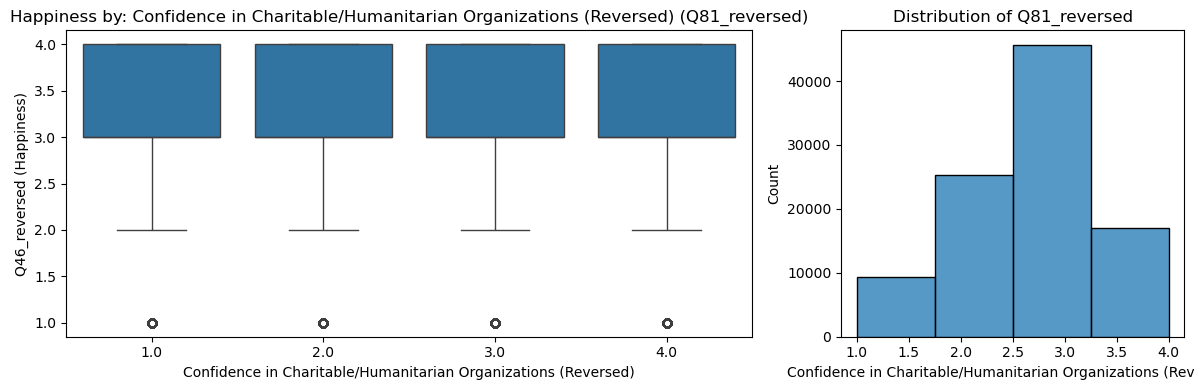

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

top_features = correlations.head(30).index.drop('Q46_reversed')

for col in top_features:
    question_text = question_mapping.get(col, col)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Boxplot
    sns.boxplot(x=prepared_df[col], y=prepared_df['Q46_reversed'], ax=axes[0])
    axes[0].set_title(f'Happiness by: {question_text} ({col})')
    axes[0].set_xlabel(question_text)
    axes[0].set_ylabel('Q46_reversed (Happiness)')

    # Right: Histogram
    sns.histplot(prepared_df[col], kde=False, bins=len(prepared_df[col].unique()), ax=axes[1])
    axes[1].set_title(f'Distribution of {col}')
    axes[1].set_xlabel(question_text)
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

top_features = correlations.head(60).index.drop('Q46_reversed')

# Create a PDF file
with PdfPages("happiness_feature_plots.pdf") as pdf:
    for col in top_features:
        question_text = question_mapping.get(col, col)

        fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})

        # Left: Boxplot of feature vs. happiness
        sns.boxplot(x=prepared_df[col], y=prepared_df['Q46_reversed'], ax=axes[0])
        axes[0].set_title(f'Happiness by: {question_text} ({col})')
        axes[0].set_xlabel(question_text)
        axes[0].set_ylabel('Q46_reversed (Happiness)')

        # Right: Histogram of feature
        sns.histplot(prepared_df[col], kde=False, bins=len(prepared_df[col].unique()), ax=axes[1])
        axes[1].set_title(f'Distribution of {col}')
        axes[1].set_xlabel(question_text)
        axes[1].set_ylabel('Count')

        plt.tight_layout()
        pdf.savefig(fig)  # Save current figure into PDF
        plt.close(fig)   

In [22]:
import pandas as pd

# Copy the original DataFrame
without_nan = prepared_df.copy()

# Drop columns with >30% missing values
threshold = 0.3
cols_to_drop = without_nan.columns[without_nan.isna().mean() > threshold]
clean2_df = without_nan.drop(columns=cols_to_drop)

# Fill remaining NaNs with mode (safely, no inplace=True)
for col in clean_df.columns:
    if clean_df[col].isna().any():
        mode_value = clean_df[col].mode()
        if not mode_value.empty:
            clean_df[col] = clean_df[col].fillna(mode_value[0])

# Drop remaining rows with any NaNs (should be minimal now)
final2_df = clean_df.dropna()

# Compare shapes and data loss
print(f"Original shape:     {prepared_df.shape}")
print(f"After column drop:  {clean_df.shape}")
print(f"Final clean shape:  {final_df.shape}")
print(f"Columns dropped:    {len(cols_to_drop)}")
print(f"Rows dropped total: {prepared_df.shape[0] - final2_df.shape[0]}")

print("\nDropped columns (>{:.0f}% NaN):".format(threshold * 100))
print(cols_to_drop.tolist())


Original shape:     (97220, 277)
After column drop:  (97220, 277)
Final clean shape:  (97220, 277)
Columns dropped:    0
Rows dropped total: 0

Dropped columns (>30% NaN):
[]


In [23]:
#LINEAR REGRESSSION

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

y = prepared_df['Q46_reversed']
X = prepared_df.drop(columns=['Q46_reversed'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R² Score: {r2:.3f}")

coeffs = pd.Series(lr_model.coef_, index=X.columns)
coeffs_named = coeffs.rename(index=question_mapping).sort_values(key=np.abs, ascending=False)

print(coeffs_named.head(10))


Mean Squared Error: 0.337
R² Score: 0.317
Life Satisfaction                                        0.18
Self-Reported Health (Reversed: Higher = Healthier)      0.16
Feeling of Security Walking Alone at Night (Reversed)    0.05
Financial Satisfaction                                   0.04
National Pride (Reversed)                                0.04
Marital Status                                          -0.03
Trust in Family (Reversed)                               0.02
Self-Described Social Class (Upper Class is higher)      0.02
Confidence in Banks (Reversed)                           0.02
Q3                                                      -0.02
dtype: float64


In [25]:
#DECISION TREE

Accuracy: 0.6363402592059247

Classification Report:
               precision    recall  f1-score   support

           1       0.50      0.05      0.10       422
           2       0.48      0.26      0.34      2317
           3       0.65      0.82      0.73     10698
           4       0.63      0.49      0.55      6007

    accuracy                           0.64     19444
   macro avg       0.57      0.41      0.43     19444
weighted avg       0.62      0.64      0.61     19444



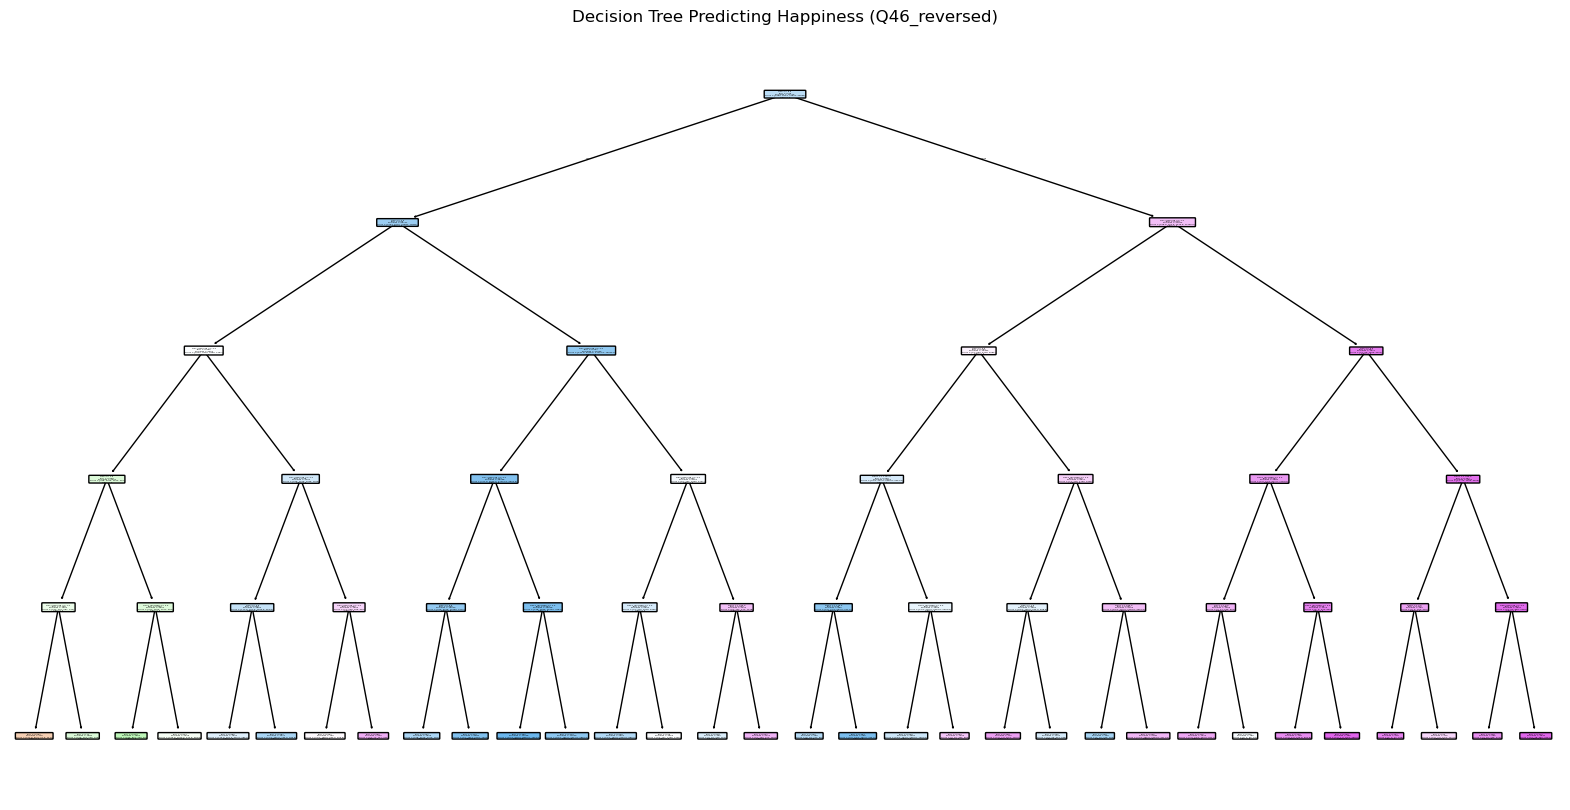

Q49             0.64
Q47_reversed    0.28
Q254_reversed   0.03
Q272            0.02
Q64_reversed    0.02
Q131_reversed   0.01
Q36             0.00
Q58_reversed    0.00
Q177            0.00
Q185            0.00
dtype: float64
Life Satisfaction                                       0.64
Self-Reported Health (Reversed: Higher = Healthier)     0.28
National Pride (Reversed)                               0.03
Q272                                                    0.02
Confidence in Churches (Reversed)                       0.02
Feeling of Security Walking Alone at Night (Reversed)   0.01
Q36                                                     0.00
Trust in Family (Reversed)                              0.00
Q177                                                    0.00
Q185                                                    0.00
dtype: float64


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

X = prepared_df.drop(columns=['Q46_reversed'])
y = prepared_df['Q46_reversed'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=['1', '2', '3', '4'], filled=True, rounded=True)
plt.title("Decision Tree Predicting Happiness (Q46_reversed)")
plt.show()

importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances[importances > 0].head(10))

importances_named = importances[importances > 0].head(10).rename(index=question_mapping)
print(importances_named)


In [27]:
#Prepare data for Classification

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

# Create Binary Target
y_binary = prepared_df['Q46_reversed'].replace({1: 'Unhappy', 2: 'Unhappy', 3: 'Happy', 4: 'Happy'})

#  Define Features (drop target)
X = prepared_df.drop(columns=['Q46_reversed','Q49','Q261']) #Removed Life Satisfaction which was similar to hapiness, and date of birth as age exists

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [29]:
print(X.shape)

(97220, 274)


In [30]:
#LOGISTIC REGRESSion

In [31]:


lr_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
)


lr_pipeline.fit(X_train, y_train)


y_pred = lr_pipeline.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance 
lr_model = lr_pipeline.named_steps['logisticregression']
scaler = lr_pipeline.named_steps['standardscaler']


scaled_features = X.columns
coeffs = pd.Series(lr_model.coef_[0], index=scaled_features)
coeffs_named = coeffs.rename(index=question_mapping).sort_values(key=np.abs, ascending=False)

print("\nTop Features Influencing 'Happy' (by coefficient magnitude):")
print(coeffs_named.head(20))



Logistic Regression Accuracy: 0.7638860316807241

 Classification Report:
               precision    recall  f1-score   support

       Happy       0.95      0.77      0.85     16705
     Unhappy       0.34      0.75      0.47      2739

    accuracy                           0.76     19444
   macro avg       0.65      0.76      0.66     19444
weighted avg       0.86      0.76      0.80     19444


Top Features Influencing 'Happy' (by coefficient magnitude):
Self-Reported Health (Reversed: Higher = Healthier)     -0.61
Financial Satisfaction                                  -0.46
Freedom of Choice and Control                           -0.25
Marital Status                                           0.17
Feeling of Security Walking Alone at Night (Reversed)   -0.16
Gone Without Cash Income                                -0.13
Trust in Family (Reversed)                              -0.12
National Pride (Reversed)                               -0.11
Family Importance (Reversed)            

In [32]:
#KNN MODEL

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=7,weights='distance')
)

knn_pipeline.fit(X_train, y_train)
y_knn_pred = knn_pipeline.predict(X_test)

print("\nKNN Accuracy:", accuracy_score(y_test, y_knn_pred))
print("\nClassification Report:\n", classification_report(y_test, y_knn_pred))


KNN Accuracy: 0.8656655009257355

Classification Report:
               precision    recall  f1-score   support

       Happy       0.87      0.99      0.93     16705
     Unhappy       0.61      0.13      0.21      2739

    accuracy                           0.87     19444
   macro avg       0.74      0.56      0.57     19444
weighted avg       0.84      0.87      0.83     19444



In [34]:
#ENSEMBLE MODEL FOR BEST RESULTS

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

xgb_model = make_pipeline(
    StandardScaler(),
    xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=3, random_state=42)
)

knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

xgb_knn_vote = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('knn', knn_model)
    ],
    voting='soft',
    weights=[2, 1]
)

xgb_knn_vote.fit(X_train, y_train)
y_vote_pred = xgb_knn_vote.predict(X_test)

print("XGBoost + KNN Soft Voting Accuracy:", accuracy_score(y_test, y_vote_pred))
print("\nClassification Report:\n", classification_report(y_test, y_vote_pred))


XGBoost + KNN Soft Voting Accuracy: 0.8769800452581773

Classification Report:
               precision    recall  f1-score   support

       Happy       0.91      0.96      0.93     16705
     Unhappy       0.59      0.40      0.48      2739

    accuracy                           0.88     19444
   macro avg       0.75      0.68      0.70     19444
weighted avg       0.86      0.88      0.87     19444

